# EP1 - Fractal de Mandelbrot utilizando bibliotecas pthreads e OpenMP

Grupo:

| Nome | NUSP |
|------|------|
| Carlos Eduardo Leal de Castro | 11921804 |
| Felipe de Lima Peressim | 11823558 |
| José Luiz Maciel Pimenta | 11896720 |
| Luis Ricardo Manrique | 5779294 |
| Rafael Fernandes Alencar | 9344730 |



## Sumário
* Configurando o ambiente
* Introdução - Conjunto de Mandelbrot
* Definindo funções e Plots
* Algorítmos: Pthreads, OpenMP
* Experimentos
    * Montando DataFrames
    * Regiões
    * Número de Threads
    * Tamanho de entrada
* Speed Up

## Configurando o ambiente <a class="anchor" id="config-bullet"></a>

Os pacotes necessários para executar os comandos deste notebook serão atualizados na célula seguinte:

In [1]:
] up

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


   Updating `~/Dropbox/IME_2020/paralela_distribuida/EP1_entrega/EP1/Project.toml`
 [no changes]
   Updating `~/Dropbox/IME_2020/paralela_distribuida/EP1_entrega/EP1/Manifest.toml`
 [no changes]


In [2]:
using DataFrames, Query, StatsPlots, Statistics, CSV, Measures

## Introdução - Conjunto de Mandelbrot <a class="anchor" id="third-bullet"></a>

O objetivo deste trabalho é gerar o Conjunto de Mandelbrot a partir de abordagens diferentes: método **sequencial**, método paralelo usando a ferramenta **Pthreads** e método paralelo usando a ferramenta **OpenMP**. Para melhor entendermos como utilizar cada método na construção deste conjunto, veremos as ideias principais por trás do Conjunto de Mandelbrot.

De maneira geral, o Conjunto de Mandelbrot é um conjunto de todos os pontos do plano complexo $\mathbb{C}$ tais que a sequência $\{z_n\}_{n \in (\mathbb{N} \cup \{0\})}$, dada por $$z_{n+1} = z_n^2 + c,$$ onde $z_0 = c \in \mathbb{C}$ e ($\mathbb{N} \cup \{0\}) = \{0,1,2,3,4,\dots\}$ permanece limitada. Isto é, para qualquer $z \in \mathbb{C}$ que pertença a esse conjunto, existe um $R_{max}$ tal que $\vert z \vert \leq R_{max}$.

Podemos representar este conjunto na forma de uma imagem 2D. Esta imagem é conhecida como Fractal de Mandelbrot. Para construí-la, representaremos cada coordenada do ponto no plano complexo como a coordenada x e y dos pixels de uma imagem bidimensional. Na imagem a seguir, os pontos definidos com a cor preta representam os pontos cuja sequência definida anteriormente são limitadas. As partes coloridas da figura representam os pontos $c \in \mathbb{C}$ que a partir de um certo número $n_c \in \mathbb{N} \cup \{0\}$ de iterações, a sequência $\vert z_{n_c} \vert > R$, para um raio $R \in \mathbb{R}$ definido.

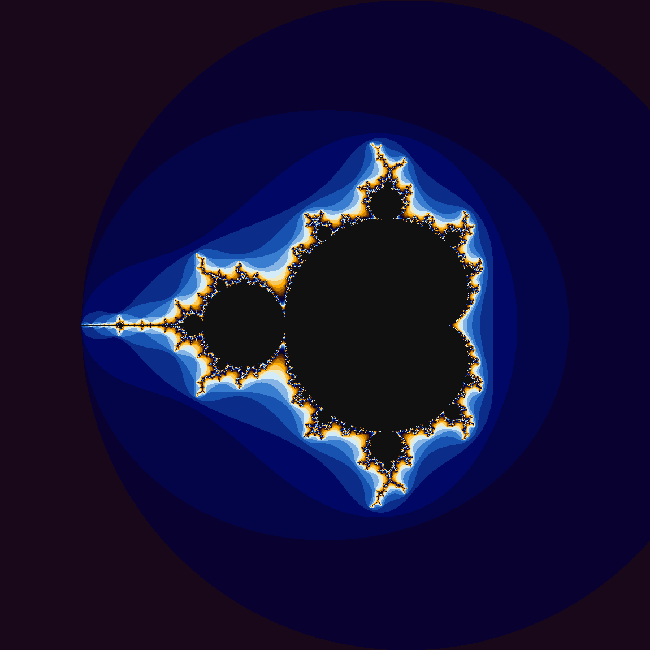

In [3]:
display("image/png", read("img/64_r.png"))

É importante observar que a quantidade de iterações máxima para gerar a imagens influencia no resultado final. Observe no gif a seguir uma sequência de imagens geradas com diferentes limites de iterações.

<img src="img/giffrac.gif" alt="Fractal de Mandelbrot" style="width:644px" align="left"/>

Portanto, para este fator não influenciar nos testes a serem realizados neste relatório, manteremos um número máximo de iterações fixo para todos os experimentos.

## Definindo funções e plots <a class="anchor" id="functions-bullet"></a>

As funções `save_csv_results` e `read_csv_results`, que salva um *Dataframe* dado em um arquivo *.csv*  e lê um arquivo *.csv* e o armazena em uma *Dataframe*, respectivamente.

In [4]:
function save_csv_results(DataFrame, tar_name)
    CSV.write(tar_name, DataFrame)
end

function read_csv_results(tar_name)    
    return CSV.read(tar_name)
end

read_csv_results (generic function with 1 method)

A função **plot_results_log** que irá gerar um gráfico contendo a média e intervalo de confiança do experimento.

In [5]:
pgfplotsx()

function plot_results_log(title, x, y, xlabel, label, yerror, min_power, max_power)      
    return scatter(x, y,
        xaxis = :log2, 
        xlabel = xlabel,
        label = label,
        ylabel = "Tempo(s)",
        xticks = [2 ^ x for x in min_power:max_power],
        yerror = yerror,
        alpha = 0.8,
        title = title,
        margin = 5.0mm)
end

plot_results_log (generic function with 1 method)

- A função **read_log_files** lê os arquivos de log gerados pelos experimentos e extrair as linhas contendo resultados e parâmetros do código executado; 
- A função **get_parameters** extrai os parâmetros do experimento;
- A função **get_duration** extrai o tempo de execução médio e o desvio padrão do experimento;
- A função **create_dataframe** irá pegar esses dados extraidos e gerar um DataFrame que poderá ser utilizado na plotagem dos gráficos.
    - Cada linha do dataframe representa um experimento e contém a sua região, tamanho da imagem, número de threads, algoritmo utilizado, média e o intervalo de confiança de 95%.  

In [6]:
function read_log_files()
    parameter_line = []
    results_line   = []
    for directory in ["mandelbrot_seq_com/", "mandelbrot_omp_com/", "mandelbrot_pth_com/", "mandelbrot_seq_sem/", "mandelbrot_omp_sem/", "mandelbrot_pth_sem/"]
        for region in ["full", "seahorse", "elephant", "triple_spiral"]
            filename = string("results/", directory, region, ".log")
            file = open(filename)
            lines = readlines(file)
            append!(parameter_line, filter((line) -> occursin("Performance", line), lines))
            append!(results_line, filter((line) -> occursin("elapsed", line), lines))  
        end
    end
    return [parameter_line, results_line]
end

read_log_files (generic function with 1 method)

In [7]:
function get_parameters(line)
    line = replace(line, " Performance counter stats for './mandelbrot_" => "")
    line = replace(line, "' (10 runs):" => "")
    line = replace(line, "-2.5 1.5 -2.0 2.0" => "Full_Picture")
    line = replace(line, "-0.8 -0.7 0.05 0.15" => "Seahorse_Valley")
    line = replace(line, "0.175 0.375 -0.1 0.1" => "Elephant_Valley")
    line = replace(line, "-0.188 -0.012 0.554 0.754" => "Triple_Spiral_Valley")
    return split(line)
end

get_parameters (generic function with 1 method)

In [8]:
function get_duration(line)
    line = replace(line, "seconds time elapsed" => "")
    line = replace(line, "( +- " => "")
    line = replace(line, "% )" => "")
    line = replace(line, "," => ".")
    return split(line)
end

get_duration (generic function with 1 method)

In [9]:
function create_dataframe()
    lines = read_log_files()
    df = DataFrame(method   = String[],
                   region   = String[],
                   size     = Int[],
                   threads  = Int[],
                   mean     = Float64[],
                   ci      = Float64[]) 

    for (parameter_line, results_line) in zip(lines[1], lines[2])
        parameters = get_parameters(parameter_line)
        results    = get_duration(results_line)
        method     = parameters[1]
        region     = parameters[2]
        size       = parse(Int, parameters[3])
        threads    = parse(Int, parameters[4])
        mean       = parse(Float64, results[1])
        ci        = parse(Float64, results[2])*1.96*mean*0.01
        push!(df, (method, region, size, threads, mean, ci))
    end
    
    unique!(df)
    print("Tamanho do Dataframe:", size(df))
    return df
end

create_dataframe (generic function with 1 method)

## Algorítmos: Sequencial, Pthreads, OpenMP <a class="anchor" id="4-bullet"></a>

### Pthreads

O trabalho para cada thread foi dividido de maneira estática, ou seja, para cada thread é especificado os pontos a serem calculados o conjunto de Mandelbrot antes da sua inicialização. Como o número de pontos a serem calculados são equidistantes nas coordenadas x e y, a divisão deu da seguinte maneira:
- Se $\sqrt{n}$ sendo $n$ o número de threads resulta em uma raiz inteira, cada thread recebe $$max_y = max_x = \left\lceil\frac{image_w}{\sqrt{n}}\right\rceil,$$ em que $max_x$ é o valor máximo para a coordenada $x$, $max_y$ é o valor máximo para a coordenada $y$, $image_w$ é a largura máxima da imagem e $n$ é o número de threads. A figura abaixo ilustra como fica esta divisão para $4$ threads:

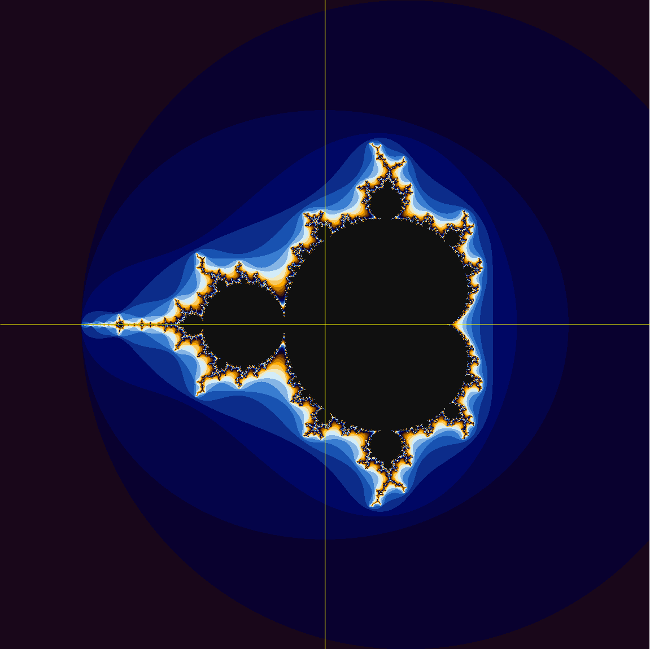

In [10]:
display("image/png", read("img/62div_r.png"))

- Se $n$ não resultar em uma raiz quadrada inteira, cada thread recebe  $$max_x = \left\lceil\dfrac{image_w}{n}\right\rceil\text{ e } max_y=image_h,$$ em que $max_x$ é o valor máximo para a coordenada $x$, $max_y$ é o valor máximo para a coordenada $y$, $image_w$ é a largura máxima da imagem, $image_h$ é a altura máxima da imagem e $n$ é o número de threads. Formando retângulos de mesmo tamanho para cada thread.

### OpenMP

A estratégia utilizada para a divisão desse mesmo trabalho, isto é, dado um ponto, calcular o conjunto de Mandelbrot, foi um pouco diferente da versão anterior. Foi definida uma unidade de trabalho baseado no número de threads, o cálculo para a unidade de trabalho está descrito na seguinte fórmula: $$max = \left\lceil\dfrac{image_w}{n}\right\rceil,$$ em que $max$ é o valor máximo para as coordenadas $x$ e $y$, $image_w$ é a largura máxima da imagem e $n$ é o número de threads. 

Com a unidade de trabalho definida, foi utilizada uma diretiva de compilação própria do openMP no qual seria atribuida 1 unidade de trabalho para cada thread. Quando elas terminarem esse trabalho, outra unidade a ela era atribuída, isso era realizado até que toda a imagem fosse calculada. O comando no código para realização desta divisão de trabalho é: `#pragma omp parallel for private(x, y) shared(max)`

## Experimentos <a class="anchor" id="experiment-bullet"></a>

A seguir, iremos executar os experimentos pedidos para analisar o desempenho de cada uma das 3 implementações: sequencial, pthreads e openmp. Nestes experimentos, mediremos o tempo médio de 10 execuções das implementações citadas, variando 4 parâmetros diferentes:

- **Regiões:** Triple Spiral, Elephant, Seahorse e Full
- **I/O e Alocação de Memória:** Com e Sem
- **Nº de Threads:** de $2^2$ até $2^5$ 
- **Tamanho da Entrada:** de $2^4$ até $2^{13}$

Para executá-los, utilizamos um shell script **run_measurements.sh** que compila as três versões do código, e em seguida executa os experimentos com todas as variações possíveis de parâmetros. Ao final teremos 560 medições diferentes:
- **Sequencial:**  80 medições (4 regiões x 10 tamanhos de entrada x 2 com/sem I/O e Alocação de memória)
- **PThreads:**   240 medições (4 regiões x 10 tamanhos de entrada x 6 nº de threads)
- **OpenMP:**     240 medições (4 regiões x 10 tamanhos de entrada x 6 nº de threads)

O tempo de execução desses experimentos foi medido utilizando o perf do linux. Esses tempos foram registrados em arquivos de log, lidos e transformados em Dataframes para geração dos gráficos.

In [11]:
# Descomentar a linha abaixo para rodar os experimentos novamente
# run(`./run_measurements.sh`)

### Montando os DataFrames <a class="anchor" id="experimentDataFrames-bullet"></a>

In [12]:
results = create_dataframe()
results[rand(1:nrow(results),10),:]

Tamanho do Dataframe:(1040, 6)

,method,region,size,threads,mean,ci
,String,String,Int64,Int64,Float64,Float64
1,pth_com,Elephant_Valley,1024,2,0.665633,0.00313114
2,pth_sem,Full_Picture,64,32,0.00120828,0.000101361
3,omp_com,Seahorse_Valley,128,1,0.0170332,2.0031e-5
4,pth_sem,Full_Picture,64,1,0.00101456,1.39198e-5
5,pth_com,Seahorse_Valley,512,2,0.159218,0.000592926
6,omp_sem,Full_Picture,4096,32,0.364277,0.00556907
7,pth_com,Seahorse_Valley,64,2,0.00319914,5.20437e-5
8,omp_sem,Full_Picture,1024,4,0.0694658,0.0021376
9,pth_sem,Elephant_Valley,512,8,0.0473371,0.0011412


In [13]:
save_csv_results(results, "results.csv")

"results.csv"

### Regiões <a class="anchor" id="experimentregioes-bullet"></a>

In [14]:
df = @from i in results begin
     @where i.size == 8192 && (occursin("seq", i.method) || i.threads == 32)
     @select {i.region, i.mean, i.ci, i.method, i.threads}
     @collect DataFrame
end

sort!(df, [:method])
first(df, 5)

,region,mean,ci,method,threads
,String,Float64,Float64,String,Int64
1,Full_Picture,4.7876,0.0215825,omp_com,32
2,Seahorse_Valley,11.1135,0.117625,omp_com,32
3,Elephant_Valley,10.7341,0.056805,omp_com,32
4,Triple_Spiral_Valley,12.2119,0.035903,omp_com,32
5,Full_Picture,1.43315,0.0258426,omp_sem,32


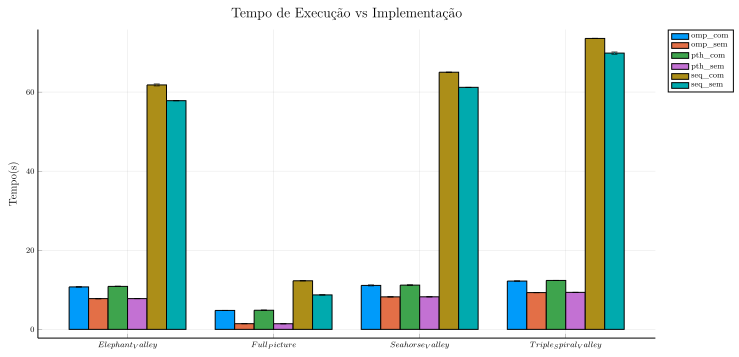

In [15]:
groupedbar(repeat(unique(df.region), outer = 6), 
           df.mean, 
           yerr = df.ci, 
           group = repeat(unique(df.method), inner = 4), 
           ylabel = "Tempo(s)", 
           title = "Tempo de Execução vs Implementação",size=(950,500))

O gráfico acima representa a comparação do tempo médio de execução da geração do Fractal de Mandelbrot, utilizando o método sequencial e métodos paralelos usando bibliotecas Pthread e OpenMP, com e sem operações de I/O e alocação de memória. A legenda indica, por cores diferentes, os métodos `omp_com` e `omp_sem` para o tempo médio de execução dos algorítmos registrando e não registrando, respectivamente, a operação de I/O e alocação de memória. Analogamente, observamos as medições dos tempos de execução para `pth_com`, `pth_sem` (Pthreads com e sem I/O e alocação de memória) e `seq_com`, `seq_sem` (Sequencial com e sem I/O e alocação de memória).

Com relação à operação de I/O e alocação de memória, observa-se que para todos os métodos e regiões, os tempos de execução para a construção do fractal são sempre menores quando não são necessárias as operações de I/O e alocação de memória. Estes processos podem requerer esperas para acessar a CPU e, por conta disso, faz com que o código seja menos eficiente. Ademais, percebe-se que o impacto nas operações de I/O e alocação de memória é mais significante na região "Full Picture" para versões paralelas. Como o tempo de alocação de memória e operações de I/O não irá mudar, levando-se em consideração os mesmos tamanhos de imagem para todas as regiões, este impacto se deve ao tempo menor de execução desta região, como foi dito anteriormente 

Podemos observar que, para um tamanho de imagem fixo $(1024 \times 1024)$ e para threads fixas (32 threads) nos métodos usando Pthreads e OpenMP, além do método sequencial, que para todas as regiões do Fractal de Mandelbrot, os métodos com estratégia de paralelização se mostram muito mais eficientes que o método sequencial. Para as regiões `Seahorse Valley`, `Elephant Valley` e `Triple Spiral Valley`, os métodos usando Pthreads e OpenMP se mostraram muito mais rápidos do que o método sequencial. Na região `Full Picture`, os métodos paralelos também se mostram mais eficientes que o método sequencial, porém com uma diferença de tempo menor do que a apresentada nas outras regiões. 

Comparando os métodos paralelos, para os parâmetros fixos ($32$ threads e $1024$ px de tamanho) e sem operação de I/O e alocação de memória, ambas as versões apresentam tempos muito próximos, em relação à média de execução, para todas as posições do fractal.

Vale ressaltar que os testes na região `Full Picture`, em geral, foram mais rápidos do que as outras regiões. Isso acontece pois, apesar do intervalo dos pontos máximo e mínimo do plano complexo (máximo e mínimo horizontal e vertical na imagem) ser maior do que nas outras regiões, a quantidade de pontos que, após serem iteradas, atingem o número máximo de iterações é menor. Isso reflete no tempo de execução menor para a região, em comparação com as outras.

### Número de Threads <a class="anchor" id="experimentntreads-bullet"></a> 

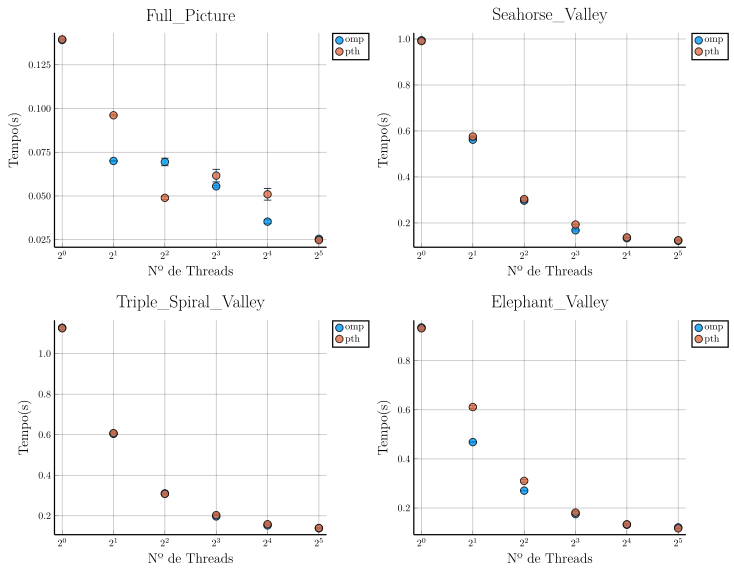

In [16]:
plot_array = Any[] 
regions = ["Full_Picture" "Seahorse_Valley" "Triple_Spiral_Valley" "Elephant_Valley"]
for region in regions
    df1 = @from i in results begin
         @where i.size == 1024 && i.region == region && i.method == "omp_sem"
         @select {i.mean, i.ci, i.method, i.threads}
         @collect DataFrame
    end
        
    df2 = @from i in results begin
         @where i.size == 1024 && i.region == region && i.method == "pth_sem"
         @select {i.mean, i.ci, i.method, i.threads}
         @collect DataFrame
    end
    
    push!(plot_array, plot_results_log(region,
                 [df1.threads df2.threads], [df1.mean df2.mean], 
                 "Nº de Threads",
                 ["omp" "pth"],
                 [df1.ci df2.ci],
                 0, 6))
end

plot(plot_array[1], plot_array[2], plot_array[3], plot_array[4], 
    layout = (2, 2), size=(1000,800), thickness_scaling=1.25, gridalpha=0.3)

Variando o número de threads utilizada para os métodos Pthread e OpenMP, para todas as regiões do fractal, observa-se que a versão OpenMP é ligeiramente mais eficiente que a versão Pthreads para $2,8,16$ e $32$ threads, para todas as regiões do fractal. Em algumas regiões específicas, para um número de threads utilizada, a versão utilizando Pthreads passa a ser mais eficiente quando comparada com a versão utilizando OpenMP, como por exemplo, na região `Full Picture` ao utilizar $4$ e $32$ threads e na região `Elephant Valley` ao utulizar $32$ threads. O fato destacado anteriormente, que compara a velocidade de execução dos métodos na região `Full Picture` com as demais regiões, se repete neste experimento. 

Podemos ver, ainda, que na região `Full Picture`, o aumento de threads reduz o tempo de execução de maneira aproximadamente linear, enquanto nas outras regiões há um aumento brusco no tempo e, com o aumento do número de threads, a redução do tempo ocorre de maneira lenta, com um comportamento próximo ao de um gráfico de exponencial negativa.

### Tamanho da Entrada<a class="anchor" id="experimententrada-bullet"></a> 

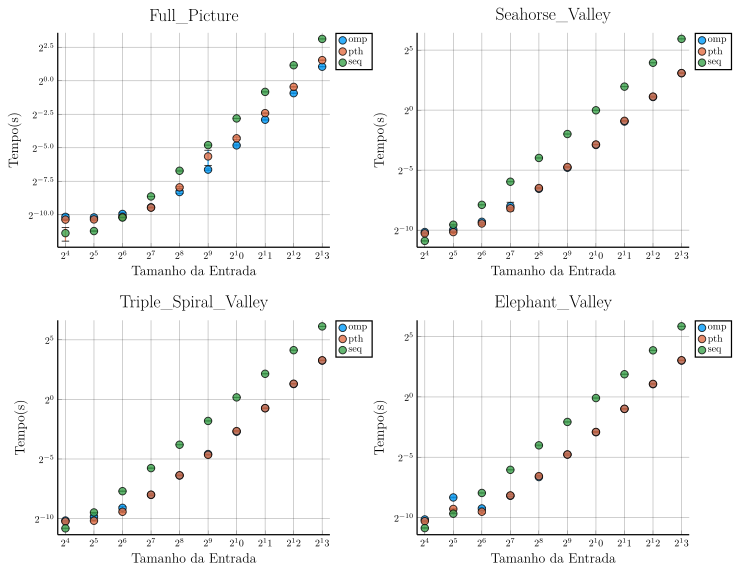

In [17]:
plot_array = Any[] 
regions = ["Full_Picture" "Seahorse_Valley" "Triple_Spiral_Valley" "Elephant_Valley"]
for region in regions
    df1 = @from i in results begin
          @where i.region == region && i.method == "omp_sem" && i.threads == 16 && i.size < 8193
          @select {i.mean, i.ci, i.method, i.size}
          @collect DataFrame
    end

    df2 = @from i in results begin
          @where i.region == region && i.method == "pth_sem" && i.threads == 16 && i.size < 8193
          @select {i.mean, i.ci, i.method, i.size}
          @collect DataFrame
    end

    df3 = @from i in results begin
          @where i.region == region && i.method == "seq_sem" && i.size < 8193
          @select {i.mean, i.ci, i.method, i.size}
          @collect DataFrame
    end
    
    push!(plot_array, plot_results_log(region,
                 [df1.size df2.size df3.size], [df1.mean df2.mean df3.mean], 
                 "Tamanho da Entrada",
                 ["omp" "pth" "seq"],
                 [df1.ci df2.ci df3.ci],
                 4, 13))
end

plot(plot_array[1], plot_array[2], plot_array[3], plot_array[4], 
    layout = (2, 2), size=(1000,800), thickness_scaling=1.25, gridalpha=0.3, yaxis=:log2)

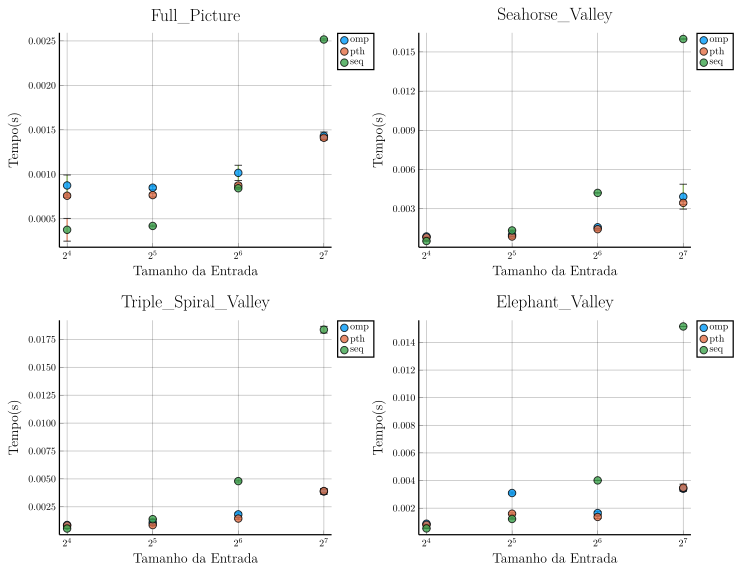

In [18]:
plot_array = Any[] 
regions = ["Full_Picture" "Seahorse_Valley" "Triple_Spiral_Valley" "Elephant_Valley"]
for region in regions
    df1 = @from i in results begin
          @where i.region == region && i.method == "omp_sem" && i.threads == 16 && i.size < 129
          @select {i.mean, i.ci, i.method, i.size}
          @collect DataFrame
    end

    df2 = @from i in results begin
          @where i.region == region && i.method == "pth_sem" && i.threads == 16 && i.size < 129
          @select {i.mean, i.ci, i.method, i.size}
          @collect DataFrame
    end

    df3 = @from i in results begin
          @where i.region == region && i.method == "seq_sem" && i.size < 129
          @select {i.mean, i.ci, i.method, i.size}
          @collect DataFrame
    end
    
    push!(plot_array, plot_results_log(region,
                 [df1.size df2.size df3.size], [df1.mean df2.mean df3.mean], 
                 "Tamanho da Entrada",
                 ["omp" "pth" "seq"],
                 [df1.ci df2.ci df3.ci],
                 4, 13))
end

plot(plot_array[1], plot_array[2], plot_array[3], plot_array[4], 
    layout = (2, 2), size=(1000,800), thickness_scaling=1.25, gridalpha=0.3)

Quando variamos o tamanho da imagem gerada, podemos observar nos gráficos, alguns comportamentos nas funções:

* A versão sequencial tem aumento no tempo médio de execução proporcional à taxa de aumento do tamanho da figura (linear).
* A versão sequencial é mais eficiente, em relação ao tempo de execução e comparando com as versões Pthread e OpenMP, para figuras muito pequenas. Na região `Full Picture`, o método sequencial é mais eficiente para figuras de tamanho $16px, 32px$ e $64px$. Já nas regiões `Seahorse Valley`, `Triple Spiral Valley` e `Seahorse Valley` a versão sequencial é mais eficiente apenas para figuras de tamanho $16px$.
* Em quase todos os testes, com versões e tamanhos diferentes, os intervalos de confiança mantém uma distância relativa pequena, em relação à média dos testes.
* Para imagens com tamanhos a partir de $64px$, o crescimento do tempo médio passa a ser linear, com escala logarítmica, para todas as regiões e métodos.

## Speedup <a class="anchor" id="speedup-bullet"></a>

Como visto na seção anterior, os algoritmos paralelos tiveram um desempenho superior ao sequencial para todas as imagens com tamanhos maiores do que $64px$. Para que fosse possível identificar o quão bem algoritmo diminui o tempo ao utilizar mais recursos, calculamos o **Speeup Teórico** e o comparamos com o desempenho do nosso algoritmo paralelo.

Para calcular o speedup, utilizamos a Lei de Amdahl, que serve para encontrar a máxima melhora esperada para um sistema em geral quando apenas uma única parte do mesmo é melhorada, conforme equação:

$$\text {Speedup}_{n}=\frac{T_{1}}{T_{n}}=\frac{1}{\frac{F_{\text {parallel}}}{n}+F_{\text {sequential}}}=\frac{1}{\frac{F_{\text {parallel}}}{n}+\left(1-F_{\text {parallel}}\right)}$$

* $n$ representa o número de processadores; 
* $F_{\text {sequential}}$ é a porção do código serial;
* $F_{\text {parallel}}$ é a porção do código paralelo.

Para identificar a parcela paralelizável do código, utilizamos a função *record* do *perf* na execução do código sequencial para a imagem Triple Spiral Valley e tamanho $4096px$. Como a função *update_rgb* está na parte que foi paralelizada e depende de acesso à memória, utilizamos 10 coletas de dados para encontrarmos a porcentagem média do uso de CPU da função alvo, pois esse tempo pode ser variável.

In [19]:
# Instalar o perf no Ubuntu fica
# sudo apt-get install linux-tools-common linux-tools-generic linux-tools-`uname -r`
# É necessário habilitar a coleta de dados para o perf com os comandos abaixo:
# sudo su
# echo 0 > /proc/sys/kernel/kptr_restrict
# chmod +x run_perf.sh
# sh -c 'echo 1 >/proc/sys/kernel/perf_event_paranoid'


# Descomentar a linha abaixo para rodar o perf novamente
# run(`./run_perf.sh`)

query = read(pipeline(`bash -c "find . -name 'mandelbrot*.data' | xargs -I {} sh -c 'perf report --sort=cpu --stdio -i {}' | grep compute_mandelbrot"`), String)
query = split(query, "--")

avg = 0
for i in [i * 2 for i in 1:10]
    avg += parse(Float64, query[i][1:end - 1])
end
avg /= 10

println("Porcentagem de uso de CPU pela função compute_mandelbrot (média de 10 medições): ", avg)

Porcentagem de uso de CPU pela função compute_mandelbrot (média de 10 medições): 95.138


In [20]:
seq_com_time = @from i in results begin
               @where i.region == "Triple_Spiral_Valley" && i.method == "seq_com" && i.size == 4096
               @select {i.mean}
               @collect DataFrame
end

total = seq_com_time.mean[1]
paralelizavel = seq_com_time.mean[1] * avg / 100

wp = paralelizavel / total
ws = 1 - wp
wp, ws

println("Tempo médio para a imagem Triple Spiral Valley, tamanho 4096, utilizando o algoritmo sequencial com IO em segundos: ", seq_com_time.mean[1])
println("\nTempo total e da parte paralelizável em segundos: ", string(total, ", "), paralelizavel)
println("\nPorcentagem serial e paralelizável: ", string(ws, ", "), wp)

Tempo médio para a imagem Triple Spiral Valley, tamanho 4096, utilizando o algoritmo sequencial com IO em segundos: 18.44825553

Tempo total e da parte paralelizável em segundos: 18.44825553, 17.551301346131403

Porcentagem serial e paralelizável: 0.048619999999999886, 0.9513800000000001


Com as porcentagens das partes serial e paralela, calculamos o **Speedup Teórico** e plotamos o gráfico a seguir

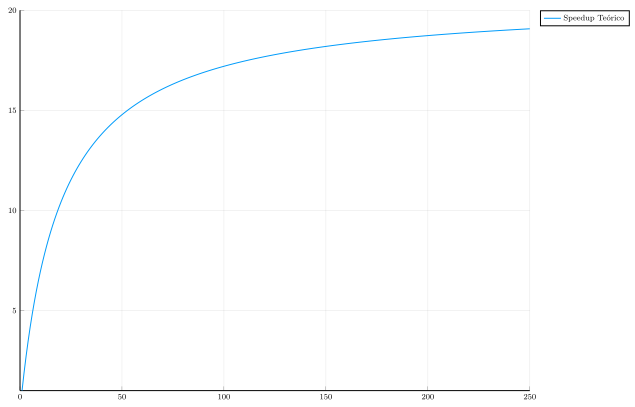

In [21]:
x_t = [i for i in 1:250]
y_t = [(1 / ((wp / i) + (1 - wp))) for i in x_t]

plot(x_t, y_t, label="Speedup Teórico", size=(800,600), ylims=(1,20), xlims=(0,250))

Para comparar o desempenho do nosso código em relação ao **Speedup Teórico**, geramos 10 resultados com o perf stats para a imagem Triple Spiral Valley, utilizando o algoritmo paralelo com pthreads e tamanho de imagem de $4096px$, repetimos o mesmo processo para o número de threads variando de 1 a 48.  

In [22]:
# Descomentar a linha abaixo para rodar o perf novamente
# run(`./run_pth.sh`)

# É necessário adicionar a permissão de execução no arquivo conforme o comando abaixo:
# chmod +x run_pth.sh

Leitura do output gerado pelo run_pth.sh e geração dos dados para o plot.

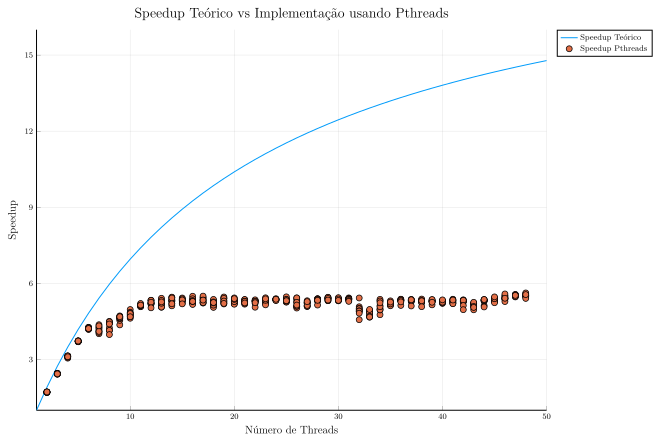

In [23]:
reader = readlines("./speedup.log")

x = Float64[]
y = Float64[]

for row in reader
    strip(row)
    if occursin("mandelbrot", row)
        push!(x, parse(Int64, split(row, " ")[end][1 : end - 2]))
    elseif occursin("seconds time elapsed", row)
        push!(y, seq_com_time.mean[1] / parse(Float64, replace(split(row, " ")[end - 3], ","=>".")))
    end
end
    
plot(x_t, y_t, label="Speedup Teórico", size=(800,600), ylabel="Speedup", xlabel="Número de Threads")
plot!(x, y, seriestype = :scatter, title = "Speedup Teórico vs Implementação usando Pthreads", xlims=(1,50), ylims=(1,16), label="Speedup Pthreads")

Com o plot acima, podemos identificar que o código escala seguindo de perto a curva do **Speedup Teórico** até o número de threads igual a 6, o que era esperado, pois o processador do computador utilizado para os testes tem 6 cores reais e 12 threads. Acima de 6 threads, o speedup continua aumentando, mas em um ritmo menor, até que fica estagnado próximo a 6, aumentamos até 48 threads e o comportamento não mudou.

A seguir, vamos utilizar um heatmap para identificar em quais combinações de tamanhos de imagens e número de threads o speedup atinge o seu pico.

In [24]:
function create_heatmap(seq, par)
    
    df_subset = @from i in results begin
            @where occursin(seq, i.method) || occursin(par, i.method)
            @select {i.region, i.method, i.mean, i.size, i.threads}
            @collect DataFrame
    end

    heatmap_data = zeros(10, 6, 4)
    sizes = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
    threads = [1, 2, 4, 8, 16, 32]
    regions = ["Full_Picture", "Elephant_Valley", "Seahorse_Valley", "Triple_Spiral_Valley"]

    for region in regions
        for thread in threads
            for size in sizes

                seq_elem = @from i in df_subset begin
                           @where i.region == region && i.method == seq && i.size == size
                           @select {i.mean}
                           @collect DataFrame
                end

                par_elem = @from i in df_subset begin
                           @where i.region == region && i.method == par && i.threads == thread && i.size == size
                           @select {i.mean}
                           @collect DataFrame
                end

                heatmap_data[findfirst(x->x==size, sizes)[1], findfirst(x->x==thread, threads)[1], 
                               + findfirst(x->x==region, regions)[1]] = 
                               + seq_elem.mean[1] / par_elem.mean[1]

            end
        end
    end
    return heatmap_data
end

create_heatmap (generic function with 1 method)

In [25]:
function plot_heatmap(heatmap_data)
    sizes = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
    threads = [1, 2, 4, 8, 16, 32]
    regions = ["Full_Picture", "Elephant_Valley", "Seahorse_Valley", "Triple_Spiral_Valley"]
    ys = [string(i) for i = sizes]
    xs = [string(i) for i = threads]
    
    p1 = heatmap(xs, ys, heatmap_data[:,:,1], xlabel="Number of Threads", ylabel=string("Sizes"), title=string("Speedup (Threads vs Sizes) - ",regions[1]))
    p2 = heatmap(xs, ys, heatmap_data[:,:,2], xlabel="Number of Threads", ylabel=string("Sizes"), title=string("Speedup (Threads vs Sizes) - ",regions[2]))
    p3 = heatmap(xs, ys, heatmap_data[:,:,3], xlabel="Number of Threads", ylabel=string("Sizes"), title=string("Speedup (Threads vs Sizes) - ",regions[3]))
    p4 = heatmap(xs, ys, heatmap_data[:,:,4], xlabel="Number of Threads", ylabel=string("Sizes"), title=string("Speedup (Threads vs Sizes) - ",regions[4]))
    plot(p1, p2, p3, p4, layout=(2,2), size=(960,800), margin=5mm)
end

plot_heatmap (generic function with 1 method)

Para o cálculo do speedup e plot do heatmap, utilizamos as médias de tempos do código sequencial e paralelo com pthreads sem IO.

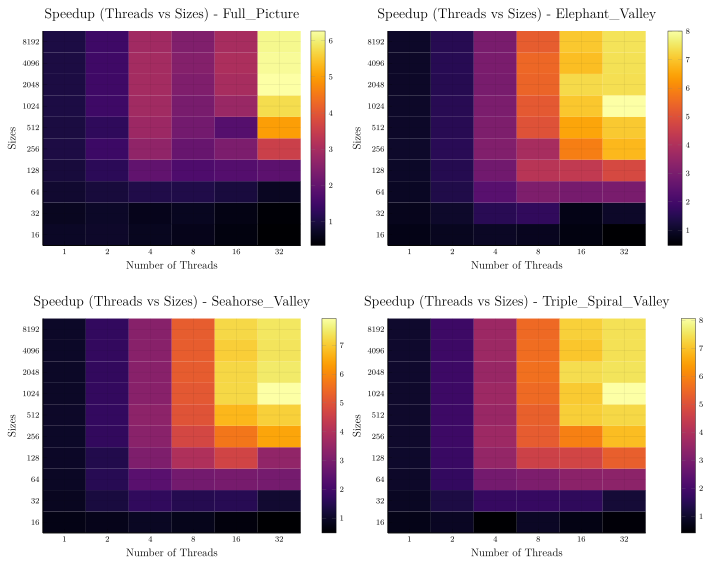

In [26]:
heatmap_data = create_heatmap("seq_sem", "pth_sem")
plot_heatmap(heatmap_data)

Com os gráficos acima, podemos confirmar as nossas afirmações quando comparamos apenas os tempos, já é possível identificar um ganho em relação ao código sequencial para imagens com tamanho acima de $16px$, porém, o máximo speedup que conseguimos com o nosso algoritmo, utilizando um processador de 6 cores, se encontra em imagens com tamanho acima de $512px$ e número de threads acima de 16.